# Adaptive Conformal Inference

Implementing the ideas from the paper *Adaptive Conformal Inference Under Distribition Shift* ([Gibbs, 2021](https://arxiv.org/pdf/2106.00170)). The paper was extended with an online multi-expert approach which can adaptively tune the parameter $\gamma$ - will leave that for now.

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from crl.utils.graphing import despine
from distrax import Normal

In [3]:
# --- Global simulation parameters ---
NUM_STEPS = 10_000            # length of time series
MU_SMOOTH_AMP = 0.006         # volatility of the latent mean µ_t
SEED = 0                     # RNG seed for reproducibility
alpha_target = 0.2            # target error rate (α)

# Learning-rates (γ) we want to test *on the same data*.
# Add or remove values as you wish.
gamma_values = [0.0001, 0.001, 0.01]


# -----------------------------------------------------------------------------
# Helper functions
# -----------------------------------------------------------------------------

def std_radius(p: float) -> jax.Array:
    """Convert central coverage p (0 < p < 1) into standard deviations for a centred Gaussian."""
    p = jnp.asarray(p)
    if jnp.any((p <= 0) | (p >= 1)):
        raise ValueError("p must lie strictly between 0 and 1")
    return jnp.sqrt(2.0) * jax.scipy.special.erfinv(p)


def true_coverage(mu: jax.Array, qhat: jax.Array) -> jax.Array:
    """Exact P(|X| ≤ q̂) when X ~ N(µ, 1)."""
    upper = qhat - mu
    lower = -qhat - mu
    return jax.scipy.special.ndtr(upper) - jax.scipy.special.ndtr(lower)


# Step 1: generate a stochastic path (µ_t, x_t)


key = jax.random.key(SEED)
mu_series = []  # length = NUM_STEPS (µ_1 … µ_T)
x_series = []   # length = NUM_STEPS (x_1 … x_T)

mu_t = 0.0  # initial latent mean
for _ in range(NUM_STEPS):
    key, mu_key, x_key = jax.random.split(key, 3)
    mu_t = Normal(mu_t, MU_SMOOTH_AMP).sample(seed=mu_key)
    x_t = Normal(mu_t, 1).sample(seed=x_key)

    mu_series.append(mu_t)
    x_series.append(x_t)

mu_series = jnp.stack(mu_series)
x_series = jnp.stack(x_series)


# Phase 2: evaluate EACH γ on the dataset

def evaluate_gamma(gamma: float, xs: jax.Array, mus: jax.Array):
    """Run the adaptive algorithm for a single γ on fixed (x_t, µ_t)."""
    alpha_t = alpha_target

    qhats, alphas, errs, covs = [], [alpha_t], [], []

    for t in range(NUM_STEPS):
        qhat_t = std_radius(1.0 - alpha_t)  # half-width of pred. interval
        err = jnp.asarray(jnp.abs(xs[t]) >= qhat_t, dtype=jnp.int32)
        alpha_t = alpha_t + gamma * (alpha_target - err)

        coverage = true_coverage(mus[t], qhat_t)

        qhats.append(qhat_t)
        alphas.append(alpha_t)
        errs.append(err)
        covs.append(coverage)

    # Pack into the same tuple structure you used before
    return list(mus), list(xs), qhats, alphas, errs, covs


# Compute results for all γ values on the shared data
results = {g: evaluate_gamma(g, x_series, mu_series) for g in gamma_values}

# `results` now maps each γ -> (µs, xs, qhats, αs, errs, covs)


/Users/alexinch/Desktop/noodling/msc_thesis/.venv/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


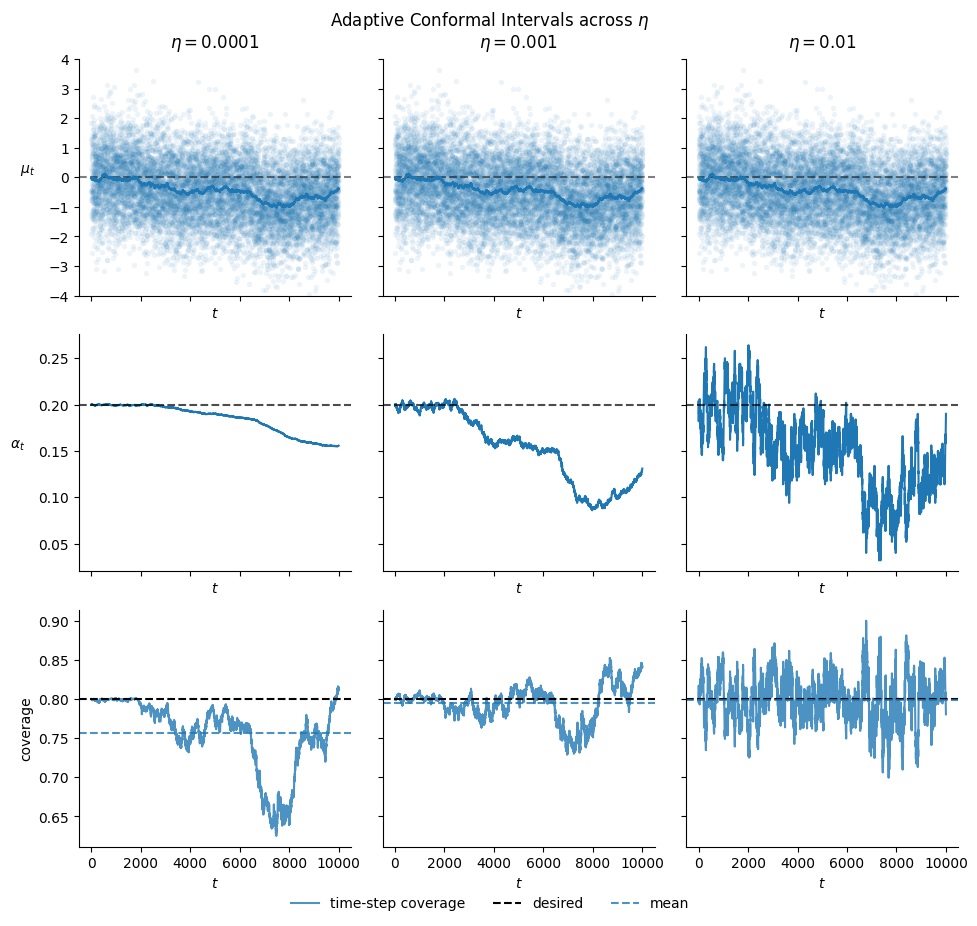

In [5]:
def aci_plot(ax_mu, ax_alpha, ax_cov, mus, xs, alphas, covs, gamma, show_ylabel) -> None:
    # --- μt -------------------------------------------------
    ax_mu.plot(mus, zorder=5)
    ax_mu.scatter(range(len(xs)), xs, s=15, alpha=0.08, linewidths=0)
    if show_ylabel:
        ax_mu.set_ylabel(r'$\mu_t$', rotation=0, labelpad=15)
    ax_mu.set_xlabel(r'$t$')
    ax_mu.set_ylim(-4, 4)
    ax_mu.axhline(0, color='k', ls='--', alpha=0.5)
    despine(ax_mu)

    # --- αt -------------------------------------------------
    ax_alpha.plot(alphas)
    if show_ylabel:
        ax_alpha.set_ylabel(r'$\alpha_t$', rotation=0, labelpad=15)
    ax_alpha.set_xlabel(r'$t$')
    ax_alpha.axhline(alpha_target, color='k', ls='--', alpha=0.7)
    despine(ax_alpha)

    # --- coverage ------------------------------------------
    ax_cov.plot(covs, label='time-step coverage', alpha=0.8)
    ax_cov.axhline(1 - alpha_target, label='desired', c='k', ls='--')
    ax_cov.axhline(np.mean(covs), label='mean', ls='--', alpha=0.8)
    if show_ylabel:
        ax_cov.set_ylabel('coverage')
    ax_cov.set_xlabel(r'$t$')
    despine(ax_cov)

    # column title
    ax_mu.set_title(fr'$\eta={gamma}$', pad=8)

# ------------------------------------------------------------------
fig, axes = plt.subplots(
    3, len(gamma_values), figsize=(len(gamma_values) * 3.3, 9),
    sharex='col', sharey='row'
)

for col, gamma in enumerate(gamma_values):
    mus, xs, qhats, alphas, errs, covs = results[gamma]
    aci_plot(
        axes[0, col], axes[1, col], axes[2, col],
        mus, xs, alphas, covs, gamma,
        show_ylabel=(col == 0)   # only leftmost column gets y-labels
    )

# Optional: legend once, under the bottom-right panel
handles, labels = axes[2, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.02))

fig.tight_layout()
fig.subplots_adjust(top=0.94)  # leave space for a global title if you want one
fig.suptitle(r'Adaptive Conformal Intervals across $\eta$', y=0.995)
plt.savefig('../results/figures/adaptive_ci/gamma_comparison.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.savefig('../results/figures/adaptive_ci/gamma_comparison.png', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()